# Preprocessing Comparison: Serial vs Parallel Implementation

In this section, we aim to preprocess images from the dataset using our custom dataloader. The objective is to compare the performance of serial execution of preprocessing functions with parallel execution using multiprocessing.

## Serial Implementation
In the serial implementation, we will apply preprocessing techniques sequentially to each image in the dataset. This allows us to understand the baseline performance of our preprocessing pipeline.

## Parallel Implementation
In the parallel implementation, we will utilize multiprocessing to distribute the preprocessing tasks across multiple CPU cores. By doing so, we aim to leverage the computational power of modern CPUs to accelerate the preprocessing pipeline.

Through this comparison, we seek to evaluate the efficiency and speedup of parallel preprocessing techniques compared to their serial counterparts.

**tqdm** has been used at various code blocks to help track the progress of long tasks
#### Machine Specifications

This Notebook was run on a machine with the following specifications 

- Hostname: c0753
- System Information: uname_result(system='Linux', node='c0753', release='3.10.0-1160.25.1.el7.x86_64', version='#1 SMP Wed Apr 28 21:49:45 UTC 2021', machine='x86_64', processor='x86_64')
- CPU Information: x86_64
- Operating System Information: posix.uname_result(sysname='Linux', nodename='c0753', release='3.10.0-1160.25.1.el7.x86_64', version='#1 SMP Wed Apr 28 21:49:45 UTC 2021', machine='x86_64')
- Number of CPUs: 28


###  Importing Necessary Packages 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
from torch.utils.data import DataLoader
import torch
import torchvision
import requests
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io
from pycocotools.coco import COCO
import matplotlib.patches as patches
import time
from tqdm import tqdm
import matplotlib.patches as mpatches
import torchvision.transforms as transforms
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import os
from collections import Counter
from torchvision.datasets import CocoDetection
from torchvision.datasets import CocoCaptions
import time
import multiprocessing
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import json
from skimage.transform import resize
import matplotlib.pyplot as plt
import multiprocessing as mp

[nltk_data] Downloading package punkt to
[nltk_data]     /home/shankar.abhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Custom Written Dataloader Class

### Vocabulary Class
This class `Vocabulary` is used to create a vocabulary for the words found in the captions of an image dataset. It initializes with special tokens such as `<pad>`, `<start>`, `<end>`, and `<unk>` for padding, start of sentence, end of sentence, and unknown words, respectively. The class provides methods to add words to the vocabulary, retrieve the index of a word, and get the length of the vocabulary.

### Building Vocabulary
The function `build_vocabulary` takes a dataset containing image-caption pairs and constructs a vocabulary based on the words found in the captions. It uses NLTK's `word_tokenize` function to tokenize each caption into words, then counts the frequency of each word. Words that meet a specified frequency threshold are added to the vocabulary using the `Vocabulary` class.

### ImageCaptionDataset Class
This class `ImageCaptionDataset` is a PyTorch Dataset implementation for loading images and their corresponding captions. It takes the image directory, data (list of dictionaries containing image filenames and captions), vocabulary, and optional transformations as inputs. In the `__getitem__` method, it loads an image, converts the caption to a list of word indices using the vocabulary, and returns the image tensor and caption tensor.


In [2]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        # Add special tokens
        self.add_word('<pad>')
        self.add_word('<start>')
        self.add_word('<end>')
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)



def build_vocabulary(data, threshold):
    """Builds a vocabulary from the dataset captions.

    Args:
        data (list): List of dictionaries with 'image' and 'caption'.
        threshold (int): Minimum word frequency to be included in the vocabulary.

    Returns:
        Vocabulary: The constructed vocabulary.
    """
    counter = Counter()
    for item in data:
        tokens = word_tokenize(item['caption'].lower())
        counter.update(tokens)

    # Create a vocabulary
    vocab = Vocabulary()

    # Add words to the vocabulary if they meet the frequency threshold
    for word, count in counter.items():
        if count >= threshold:
            vocab.add_word(word)

    return vocab

class ImageCaptionDataset(Dataset):
    def __init__(self, img_dir, data, vocab, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            data (list): List of dictionaries with 'image' and 'caption'.
            vocab (Vocabulary): Vocabulary instance.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.img_dir = img_dir
        self.data = data
        self.vocab = vocab
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.img_dir, self.data[idx]['image'])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Convert caption to list of word indices
        caption = self.data[idx]['caption']
        tokens = word_tokenize(caption.lower())
        caption_indices = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]
        
        return image, torch.tensor(caption_indices)
    


# 1.1 Image Preprocessing Functions and Dataset Loading

In this section, we define several image preprocessing functions and load the dataset for further analysis.

## About the Dataset

We have used a Dataset of 1.5GB to showcase the parallelism implemented by Multiprocessing. Using a large dataset over 6GB consisted of over 40000 images which led to memory errors. 

## Image Preprocessing Functions
We define the following image preprocessing functions:

1. **Resize Image**: Resizes the input image to a specified size of 256x256 pixels.
2. **Normalize Image**: Normalizes pixel values of the input image to the range [0, 1].
3. **Standardize Image**: Standardizes the input image by dividing it by its standard deviation.
4. **Flip Image**: Flips the input image horizontally (left to right).

These functions will be applied to each image in the dataset to perform various preprocessing tasks.

## Dataset Loading
The dataset is loaded using the `getData()` function. This function reads the annotations and image directory paths, constructs a vocabulary, and creates an instance of the `ImageCaptionDataset` class. The dataset contains image-caption pairs for training purposes.


In [3]:
def resize_img(sample):
    processed_img =  resize(sample,(256, 256))
    return processed_img

def normalize_img(sample):
    img_array_normalized = sample / 255.0  # Normalize pixel values to [0, 1]
    return img_array_normalized

def standardize_img(sample):
    img_std = np.std(sample)
    img_standardized = sample / img_std
    return img_standardized

def flip_img(sample):
    img_std = np.fliplr(sample)
    return img_std

def getData():
    annotations = "/home/shankar.abhi/csye/Final_Project/COCO/caption_data_75k.json"
    image_dir = "/home/shankar.abhi/csye/Final_Project/COCO/coco_75k"

    annotations = "/home/shankar.abhi/csye/Final_Project/COCO/caption_data_40k.json"
    image_dir = "/home/shankar.abhi/csye/Final_Project/COCO/coco_40k"
    annotations = "/home/shankar.abhi/csye/Final_Project/datasets/combined_data.json"
    image_dir = '/home/shankar.abhi/csye/Final_Project/datasets/coco_1k'    
    annotations = "/scratch/shankar.abhi/caption_data_10k.json"
    image_dir = "/scratch/shankar.abhi/coco_10k"
    
    with open(annotations, 'r') as f:
        json_data = json.load(f)

    #extracts the vocabulary to build the captions for the dataset    
    ann = []
    for filename, data in json_data.items():
        image_id = data['image_id']
        caption = data['caption']
        ann.append({"image": filename, "caption": caption})

    vocab = build_vocabulary(ann, 1)
    transform = np.array
    # Assuming you have 'data' as your list of dictionaries and 'vocab' ready
    train_dataset = ImageCaptionDataset(img_dir=image_dir, data=ann, vocab=vocab, transform = transform)
    loader = DataLoader(train_dataset, batch_size=1000,collate_fn=lambda x: tuple(zip(*x)), shuffle=True,pin_memory=True)
    return loader

# 1.2 Extracting Just Images to a list

In [4]:
loader = getData()
images_list = []

for batch_images, batch_captions in loader:
    images_list.extend(batch_images)
len(images_list)    

10000

# 1.3  Plotting some of the Preprocessing Techniques 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


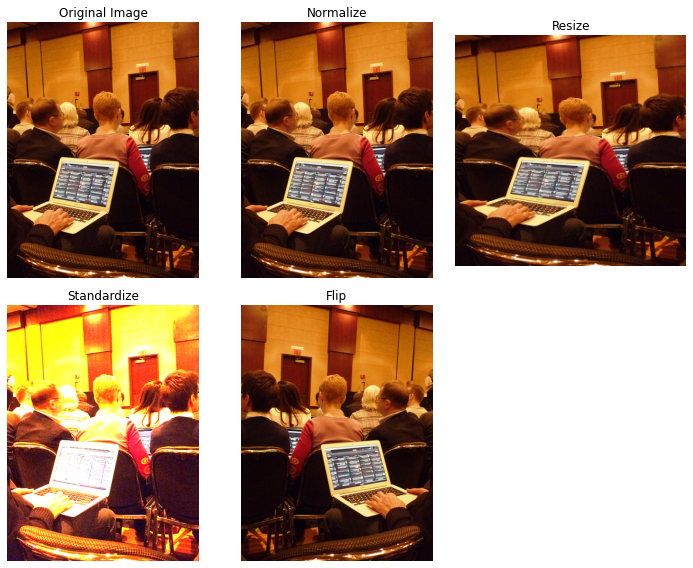

In [5]:

# Plot original image
plt.figure(figsize=(10, 8))
plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(images_list[0])
plt.axis('off')

# Plot images after each transformation
functions = [normalize_img, resize_img, standardize_img, flip_img]
function_names = ['Normalize', 'Resize', 'Standardize', 'Flip']
for i, (function, name) in enumerate(zip(functions, function_names), start=2):
    transformed_img = function(images_list[0])
    plt.subplot(2, 3, i)
    plt.title(name)
    plt.imshow(transformed_img)
    plt.axis('off')

plt.tight_layout()
plt.show()


# 2. Methodology


### 2.1 Parallelism  using Multiprocessing 

Here we leverage the `Multiprocessing` package of Python to Showcase paralleism. We have implemented the 2 main types of Multiprocessing which are Synchronronous (ex : apply, map, starmap, imap) and Asynchronous (ex : apply_async, map_async, starmap_async). We have taken the imap and apply_async just to showcase the two types of parallelism 

### 2.1.1 Why *apply_async* and *imap*?

- **imap :**
  - We opted for `imap` due to its ability to handle large chunksizes efficiently and its faster performance compared to `map`.
  - `imap` consumes lesser memory, making it suitable for processing large datasets.

- **Asynchronous Functionality with apply_async:**
  - Asynchronous processing does not have a fixed process order, potentially resulting in mixed results.
  - Using asynchronous functions like `apply_async`, we can apply the function and receive the output using a simple for loop.
  - In contrast to synchronous processing, the number of child processes produced in asynchronous processing is independent. This reduces memory strain caused by creating additional child processes.
  - This independence is crucial, as synchronous methods using `os.fork` to create additional child processes can lead to severe out-of-memory problems, especially with large datasets.
  - Applying `map_async` and `starmap_async`, and using the `get` function to retrieve results, can strain memory due to large tensors being brought from memory, resulting in slower performance.
  - Introducing a dataloader for parallel asynchronous operations and batching the data can help prevent out-of-memory errors.


We have used an environemt with almost 20 CPUs to compare parallelism just to see how multiprocessing works as the number of workers/processes increase. Hence we have done various preorcessiung steps at

1. 1 process 
2. 10 processes
3. 20 processes

Important aspects to know when using Multiprocessing in Python. 

1. For Loops - When implementing multiprocessing with for loops, the number of subprocesses and child processes released increases exponentially with the number of processes. Consequently, the memory allocated to each child process also increases, which can lead to memory errors, as illustrated below:


**Example Error when running too many processes:**

---------------------------------------------------------------------------
/shared/centos7/anaconda3/2021.05/lib/python3.8/multiprocessing/popen_fork.py in _launch(self, process_obj)
     68         parent_r, child_w = os.pipe()
     69         child_r, parent_w = os.pipe()
---> 70         self.pid = os.fork()
     71         if self.pid == 0:
     72             try:

OSError: [Errno 12] Cannot allocate memory

---------------------------------------------------------------------------

**Solution**

os.fork() makes a copy of a process, so if you're sitting at about 18 GB of usage, and want to call fork, you need another 18 GB. Twice 18 is 36 GB, which is well over 32 GB. If it is not possible to increase computational power or memory remember to terminate the processes and to ensure they are ended using `pool.close()` and/or `pool.join()`. Another solution would be to limit the number of task per child process `multiprocessing.Pool(maxtasksperchild=1)`


### 2.2 Serial Implementation

When it comes to serial implementation we use the 2 most basic operations. 

1. For Loops 
2. Map (Pythons in built function)


# 3. Implementation

The code measures the processing time for different image processing functions using both `apply_async` and `imap` methods from the `multiprocessing` package. 

It iterates over a list of image processing functions (normalize, resize, standardize, flip) and for each function, it processes a list of images using multiprocessing with a specified number of processes. 

For each function, it records the processing time using both `apply_async` and `imap` methods and stores the results in a pandas DataFrame.


## 3.1  Minimum number of Processes : 1
We begin with a modest number of processes to initiate multiprocessing.

In [6]:
%timeit

min_processes = 1
max_processes = multiprocessing.cpu_count()
# Lists to store processing times  
imap_list = []
serial_processing_times = []
apply_async_list = []
multiprocess_n =  [1,10,20]#range(min_processes, max_processes + 1,2)

for function in [normalize_img,resize_img,standardize_img,flip_img]:


    #print("Dataset  Size : ", len(train_dataset))
    print("Minimum Process is :", min_processes)
    print("Maximum Process is :", max_processes)
    num_processes = multiprocess_n[0]
    # Iterate over number of processes
        
    import numpy as np

    batch_size = 1000  # Adjust the batch size as needed

    # Measure processing time using APPLY ASYNC with batches
    start_time = time.time()


    with multiprocessing.Pool(processes=num_processes) as pool:
        # Wrap tqdm around the entire multiprocessing process
        with tqdm(total=len(images_list)) as progress:
            for i in range(0, len(images_list), batch_size):
                batch = images_list[i:i+batch_size]

                # Process batch using apply_async
                results = [pool.apply_async(function, (data,)) for data in batch]
                for result in results:
                    result.get(5)  # Retrieve the result from apply_async()
                    progress.update(1)  # Update progress bar for each processed image
                del results
    #Time Stored in List
    parallel_processing_time_apply_async = time.time() - start_time
    apply_async_list.append(parallel_processing_time_apply_async)


    # Measure processing time using IMAP
    start_time = time.time()
    with multiprocessing.Pool(processes=num_processes) as pool:
        with tqdm(pool.imap(function, images_list)) as parallel_processed_images_imap:
            for _ in parallel_processed_images_imap:
                pass
        pool.close()
        pool.join()
            #print("Done IMAP")
    #Time Stored in List            
    parallel_processing_time_imap = time.time() - start_time    
    imap_list.append(parallel_processing_time_imap)
        
df1 = pd.DataFrame({
    'Function': ['Normalize', 'Resize', 'Standardize', 'Flip'],    
    'IMAP Processing Time': imap_list,
    'Apply Async Processing Time': apply_async_list
})

Minimum Process is : 1
Maximum Process is : 28


100%|██████████| 10000/10000 [01:33<00:00, 107.20it/s]
10000it [01:27, 113.94it/s]


Minimum Process is : 1
Maximum Process is : 28


100%|██████████| 10000/10000 [04:48<00:00, 34.71it/s]
10000it [04:51, 34.31it/s]


Minimum Process is : 1
Maximum Process is : 28


100%|██████████| 10000/10000 [02:51<00:00, 58.27it/s]
10000it [01:53, 88.11it/s]


Minimum Process is : 1
Maximum Process is : 28


100%|██████████| 10000/10000 [01:13<00:00, 135.45it/s]
10000it [01:11, 139.27it/s]


## 3.1.2 10 Processes 

Increasing the Number of Processes to 10.

In [7]:
%timeit

min_processes = 1
max_processes = multiprocessing.cpu_count()

# Lists to store processing times  
imap_list = []
serial_processing_times = []
apply_async_list = []

#List of Processes
multiprocess_n =  [1,10,20]

# Looping Over every function
for function in [normalize_img,resize_img,standardize_img,flip_img]:

    num_processes = multiprocess_n[1]
    print("Current Process is :", num_processes)
    # Iterate over number of processes
    #for num_processes in multiprocess_n:
        
    import numpy as np

    batch_size = 1000  # Adjust the batch size as needed

    # Measure processing time using APPLY ASYNC with batches
    start_time = time.time()


    with multiprocessing.Pool(processes=num_processes) as pool:
        # Wrap tqdm around the entire multiprocessing process
        with tqdm(total=len(images_list)) as progress:
            for i in range(0, len(images_list), batch_size):
                batch = images_list[i:i+batch_size]

                # Process batch using apply_async
                results = [pool.apply_async(function, (data,)) for data in batch]
                for result in results:
                    result.get(5)  # Retrieve the result from apply_async()
                    progress.update(1)  # Update progress bar for each processed image
                del results

    parallel_processing_time_apply_async = time.time() - start_time
    apply_async_list.append(parallel_processing_time_apply_async)


    # Measure processing time using IMAP
    start_time = time.time()
    with multiprocessing.Pool(processes=num_processes) as pool:
        with tqdm(pool.imap(function, images_list)) as parallel_processed_images_imap:
            for _ in parallel_processed_images_imap:
                pass
        pool.close()
        pool.join()
            #print("Done IMAP")
    parallel_processing_time_imap = time.time() - start_time    
    imap_list.append(parallel_processing_time_imap)
        
df2 = pd.DataFrame({
    'Function': ['Normalize', 'Resize', 'Standardize', 'Flip'],    
    'IMAP Processing Time': imap_list,
    'Apply Async Processing Time': apply_async_list
})        

Current Process is : 10


100%|██████████| 10000/10000 [01:45<00:00, 95.08it/s]
10000it [01:05, 151.70it/s]


Current Process is : 10


100%|██████████| 10000/10000 [00:37<00:00, 265.31it/s]
10000it [00:37, 269.78it/s]


Current Process is : 10


100%|██████████| 10000/10000 [01:42<00:00, 97.83it/s]
10000it [01:03, 156.85it/s]


Current Process is : 10


100%|██████████| 10000/10000 [00:14<00:00, 676.87it/s]
10000it [00:14, 671.15it/s]


## 3.3 20 Processes

Here, we explore the impact of increasing the number of workers to 20 to observe if it accelerates the function application process.

In [8]:
%timeit
min_processes = 1
max_processes = multiprocessing.cpu_count()
# Lists to store processing times  
imap_list = []
serial_processing_times = []
apply_async_list = []
multiprocess_n =  [1,10,20]#range(min_processes, max_processes + 1,2)
for function in [normalize_img,resize_img,standardize_img,flip_img]:
    num_processes = multiprocess_n[2]
    print("Current Process is :", num_processes)

    # Iterate over number of processes        
    import numpy as np

    batch_size = 1000  # Adjust the batch size as needed

    # Measure processing time using APPLY ASYNC with batches
    start_time = time.time()


    with multiprocessing.Pool(processes=num_processes) as pool:
        # Wrap tqdm around the entire multiprocessing process
        with tqdm(total=len(images_list)) as progress:
            for i in range(0, len(images_list), batch_size):
                batch = images_list[i:i+batch_size]

                # Process batch using apply_async
                results = [pool.apply_async(function, (data,)) for data in batch]
                for result in results:
                    result.get(5)  # Retrieve the result from apply_async()
                    progress.update(1)  # Update progress bar for each processed image
                del results

    parallel_processing_time_apply_async = time.time() - start_time
    apply_async_list.append(parallel_processing_time_apply_async)


    # Measure processing time using IMAP
    start_time = time.time()
    with multiprocessing.Pool(processes=num_processes) as pool:
        with tqdm(pool.imap(function, images_list)) as parallel_processed_images_imap:
            for _ in parallel_processed_images_imap:
                pass
        pool.close()
        pool.join()
            #print("Done IMAP")
    parallel_processing_time_imap = time.time() - start_time    
    imap_list.append(parallel_processing_time_imap)

df3 = pd.DataFrame({
    'Function': ['Normalize', 'Resize', 'Standardize', 'Flip'],    
    'IMAP Processing Time': imap_list,
    'Apply Async Processing Time': apply_async_list
})                

Current Process is : 20


100%|██████████| 10000/10000 [01:45<00:00, 94.69it/s]
10000it [01:06, 151.30it/s]


Current Process is : 20


100%|██████████| 10000/10000 [00:34<00:00, 290.05it/s]
10000it [00:26, 380.73it/s]


Current Process is : 20


100%|██████████| 10000/10000 [01:53<00:00, 88.47it/s]
10000it [01:12, 138.19it/s]


Current Process is : 20


100%|██████████| 10000/10000 [00:16<00:00, 615.71it/s]
10000it [00:15, 637.82it/s]


## 3.4 Serial Processing Time

Calculating the time taken for the Code Block to run serially. 

In [9]:
%timeit
serial_map_list = []
serial_for_loop_list = []

for function in [normalize_img,resize_img,standardize_img,flip_img]:
    # Perform serial preprocessing - Map
    start_time = time.time()
    serial_processed_images = list(map(lambda x: function(x), images_list))
    serial_processing_time_map = time.time() - start_time
    serial_map_list.append(serial_processing_time_map)

    # Perform serial preprocessing - For Loop
    start_time = time.time()
    for x in images_list:
        y = function(x)
    serial_processing_time_for_loop = time.time() - start_time
    serial_for_loop_list.append(serial_processing_time_for_loop)

    
df = pd.DataFrame({
    'Function': ['Normalize', 'Resize', 'Standardize', 'Flip'],
    'Serial Map Time': serial_map_list,
    'Serial For Loop Time': serial_for_loop_list,
})

# 4. Combining Data

In this section, we aggregate and analyze the processing data obtained from different numbers of processes. 

Speedup Calculation: We calculate the speedup for both synchronous and asynchronous processing methods. Speedup is computed as the ratio of the serial map time to the minimum processing time (either IMAP or Apply Async).

$Speedup = \frac{Serial\:Execution\:Time}{Parallel\:Execution\:Time}$


Efficiency Calculation: For synchronous processing, we calculate efficiency, which is the speedup divided by the number of processes.

$ Efficiency = \frac{Speedup}{Number\:of\:Processes}$


Output: The resulting DataFrame main_df contains the consolidated data along with speedup and efficiency metrics, which can be further analyzed to understand the performance impact of varying the number of processes.

In [10]:
wd = '/home/shankar.abhi/csye/Final_Project/figures/'    
main_df = pd.DataFrame()
for vals,d in zip([df1.copy(), df2.copy(), df3.copy()],[1,10, 20]):
    a = vals.merge(df.copy(), on = 'Function')
    a['Process'] = d
    #print(a)
    main_df = pd.concat([main_df,a])

main_df['Speedup_Sync'] = main_df['Serial Map Time']/main_df['IMAP Processing Time']
main_df['Speedup_Async'] = main_df['Serial Map Time']/main_df['Apply Async Processing Time']      
main_df['Efficiency_Sync'] = main_df['Speedup_Sync'] / main_df['Process']
main_df['Efficiency_Async'] = main_df['Speedup_Async'] / main_df['Process']
print(main_df)

      Function  IMAP Processing Time  Apply Async Processing Time  \
0    Normalize             88.106998                    93.594545   
1       Resize            291.784198                   288.509827   
2  Standardize            113.899992                   172.045612   
3         Flip             72.159033                    74.285519   
0    Normalize             67.879061                   106.795634   
1       Resize             38.923134                    39.699008   
2  Standardize             65.743488                   104.129845   
3         Flip             16.585731                    16.919407   
0    Normalize             70.185216                   108.951375   
1       Resize             30.266224                    38.672048   
2  Standardize             77.051173                   116.771295   
3         Flip             19.049451                    21.196394   

   Serial Map Time  Serial For Loop Time  Process  Speedup_Sync  \
0        44.070233             14.8

## 5. Visualisation

Plotting the above dataset to visualise the following. 

1. IMAP Processing Time for Each Function

2. Apply Async Processing Time for Each Function

3. Serial Map Time for Each Function

4. Serial For Loop Time for Each Function

5. Speedup Achieved for Each Function

6. Efficiency Achieved for Each Function


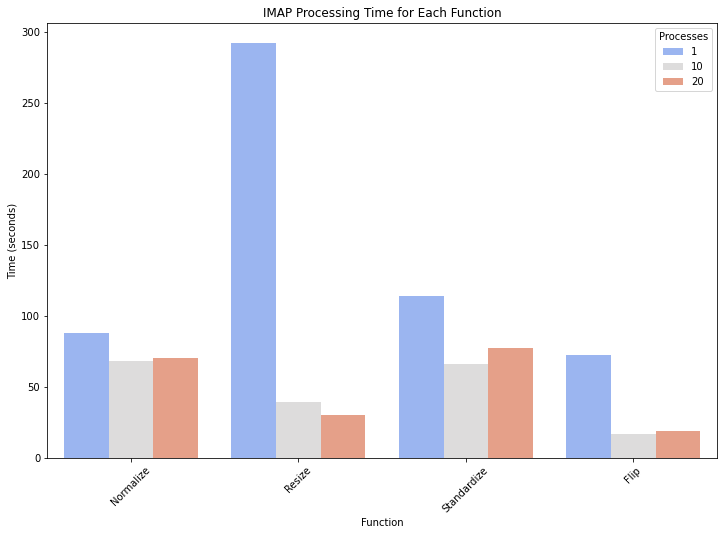

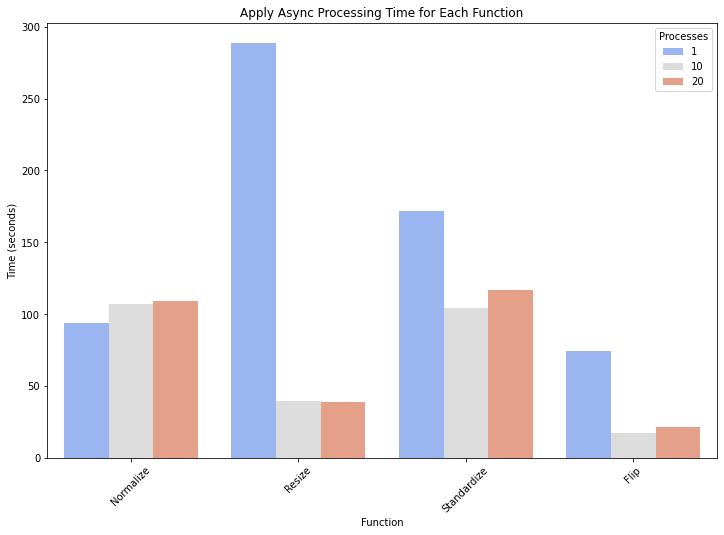

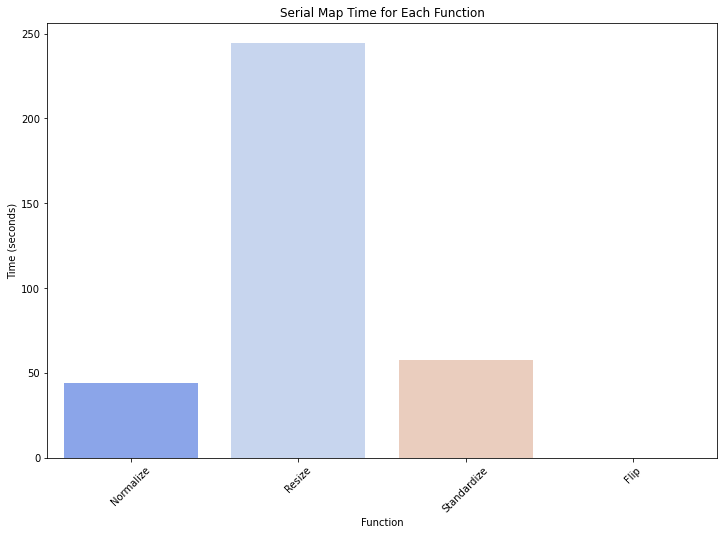

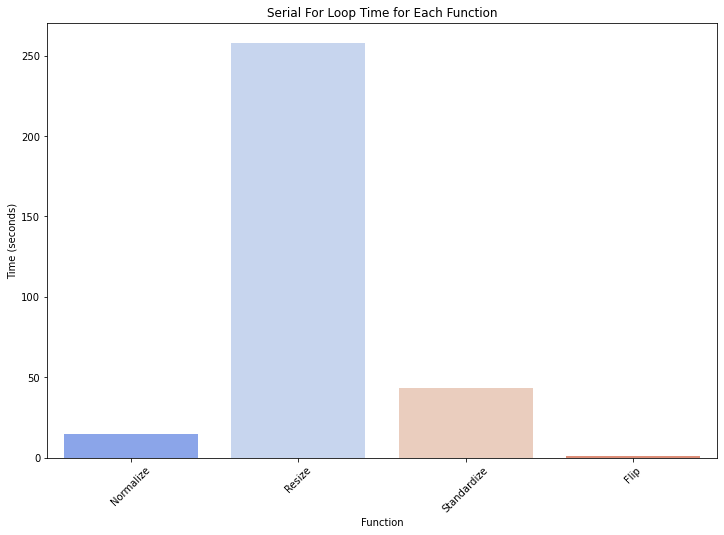

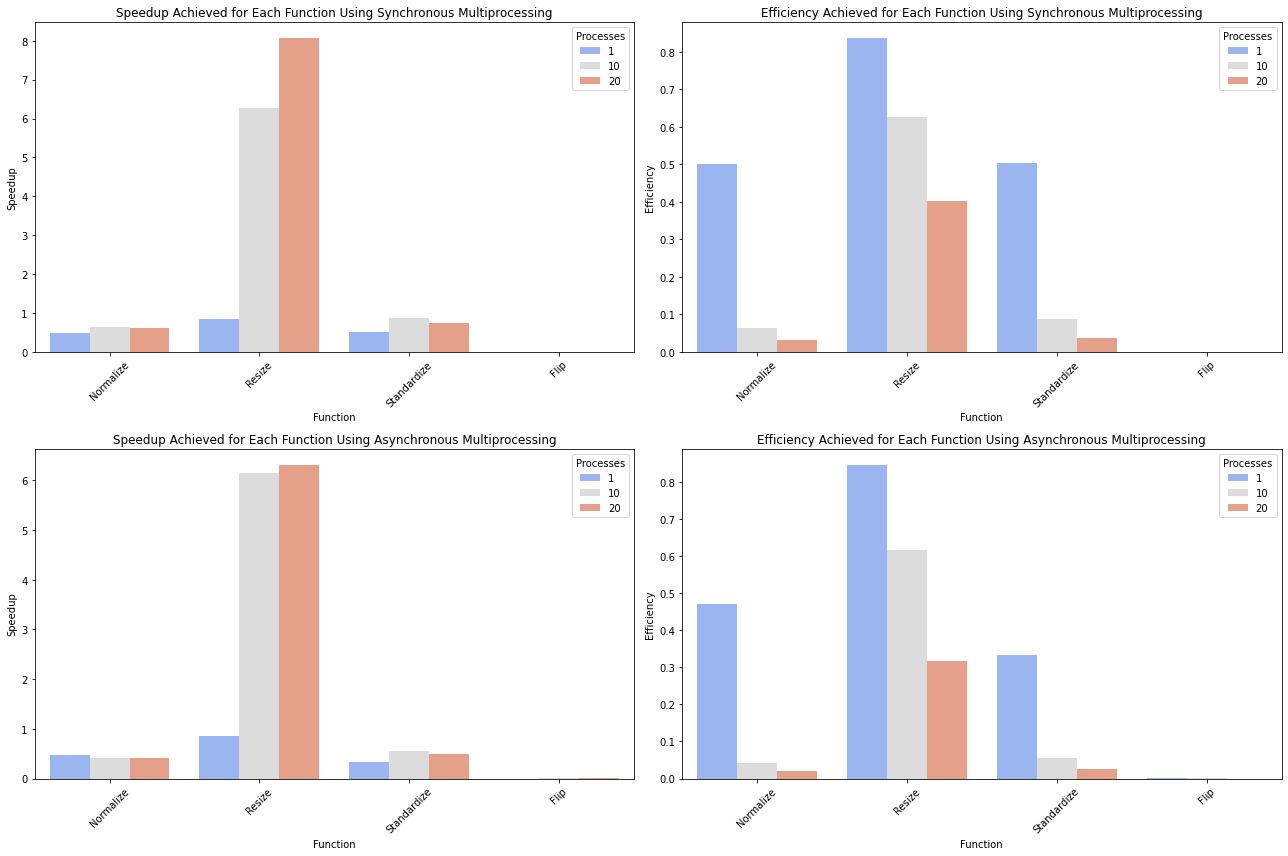

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
wd = '/home/shankar.abhi/csye/Final_Project/figures/'    
# Plot time taken for each function
plt.figure(figsize=(12, 8))
sns.barplot(data=main_df, x='Function', y='IMAP Processing Time', hue='Process', palette='coolwarm')
plt.title('IMAP Processing Time for Each Function')
plt.xlabel('Function')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Processes')
plt.savefig(wd+'IMAP Processing Time for Each Function.png'.replace(" ","_"))
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=main_df, x='Function', y='Apply Async Processing Time', hue='Process', palette='coolwarm')
plt.title('Apply Async Processing Time for Each Function')
plt.xlabel('Function')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Processes')
plt.savefig(wd+'Apply Async Processing Time for Each Function.png'.replace(" ","_"))
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=main_df, x='Function', y='Serial Map Time', palette='coolwarm')
plt.title('Serial Map Time for Each Function')
plt.xlabel('Function')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.savefig(wd+'Serial Map Time for Each Function.png'.replace(" ","_"))
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=main_df, x='Function', y='Serial For Loop Time', palette='coolwarm')
plt.title('Serial For Loop Time for Each Function')
plt.xlabel('Function')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.savefig(wd+'Serial For Loop Time for Each Function.png'.replace(" ","_"))
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Set up a grid layout for the plots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plot speedup and efficiency for synchronous multiprocessing
sns.barplot(data=main_df, x='Function', y='Speedup_Sync', hue='Process', palette='coolwarm', ax=axs[0, 0])
axs[0, 0].set_title('Speedup Achieved for Each Function Using Synchronous Multiprocessing')
axs[0, 0].set_xlabel('Function')
axs[0, 0].set_ylabel('Speedup')
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].legend(title='Processes')

sns.barplot(data=main_df, x='Function', y='Efficiency_Sync', hue='Process', palette='coolwarm', ax=axs[0, 1])
axs[0, 1].set_title('Efficiency Achieved for Each Function Using Synchronous Multiprocessing')
axs[0, 1].set_xlabel('Function')
axs[0, 1].set_ylabel('Efficiency')
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].legend(title='Processes')

# Plot speedup and efficiency for asynchronous multiprocessing
sns.barplot(data=main_df, x='Function', y='Speedup_Async', hue='Process', palette='coolwarm', ax=axs[1, 0])
axs[1, 0].set_title('Speedup Achieved for Each Function Using Asynchronous Multiprocessing')
axs[1, 0].set_xlabel('Function')
axs[1, 0].set_ylabel('Speedup')
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].legend(title='Processes')

sns.barplot(data=main_df, x='Function', y='Efficiency_Async', hue='Process', palette='coolwarm', ax=axs[1, 1])
axs[1, 1].set_title('Efficiency Achieved for Each Function Using Asynchronous Multiprocessing')
axs[1, 1].set_xlabel('Function')
axs[1, 1].set_ylabel('Efficiency')
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].legend(title='Processes')

# Adjust layout spacing
plt.tight_layout()

# Save the figure
plt.savefig(wd + 'Multiprocessing_Comparison_Plots.png'.replace(" ", "_"))

# Show the plots
plt.show()

# 6. Conclusion

## Time taken by Serial, IMAP, and Apply Async:

Serial execution takes the longest time among all methods for each process (Normalize, Resize, Standardize, Flip).
IMAP processing generally takes longer than Apply Async processing for all processes. This is because of the fact that processes are not queued in Asynchronous multiprocessing methods


## Speedup by IMAP and Apply Async:

Speedup is calculated as the ratio of Serial Map Time to IMAP or Apply Async Time.
IMAP generally provides significant speedup compared to serial execution, especially for processes like Resize and Standardize.
Apply Async also shows considerable speedup compared to serial execution but generally is slightly slower than IMAP.

## Efficiency of IMAP and Apply Async:

Efficiency is calculated as the ratio of Speedup to the number of processes.
IMAP and Apply Async efficiencies vary across processes, with IMAP being generally more efficient than Apply Async.
Efficiency tends to decrease as the number of processes increases, indicating diminishing returns with more parallel processes. This can be due to increased overhead : **with too many processes either file I/O or network I/O will become a bottleneck and the program will slow down because of the additional overhead needed for process switching.**